<font size="4">**Importing Required Libraries**</font> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style= "whitegrid", font_scale=1.3)

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import spacy
nlp = spacy.load('en_core_web_md') 

<font size="4">**Loading the Dataset**</font> 

In [5]:
df= pd.read_csv('zomato.csv')

<font size="4">**Examining the Dataset**</font>

In [6]:
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banashankari?context=eyJzZSI6eyJlIjpbNTg2OTQsIjE4Mzc1NDc0IiwiNTkwOTAiLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHMgaW4gQmFu...,"942, 21st Main Road, 2nd Stage, Banashankari, Bangalore",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Lajawab, Tomato Shorba, Dum Biryani, Sweet Corn Soup","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephant-banashankari?context=eyJzZSI6eyJlIjpbIjU4Njk0IiwxODM3NTQ3NCwiNTkwOTAiLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHM...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th Block, Kathriguppe, 3rd Stage, Banashankari, Bangalore",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai Green Curry, Paneer Tikka, Dum Biryani, Chicken Biryani","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for dinner with family. Turned out to be a good choose suitable for all ages of people. Can try this place. We liked the most was their starters. Service is ...",[],Buffet,Banashankari


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

<font size="6">**Data Preparation and Processing**</font>

<font size="3">**(1) Calculating % of missing values in each column**</font>

In [8]:
a = df.isnull().sum()/len(df)*100
missing_data = pd.DataFrame({'Missing Value %' :a}).sort_values('Missing Value %',ascending=False)
missing_data.head(8)

,Missing Value %
dish_liked,54.291626
rate,15.033741
phone,2.335789
approx_cost(for two people),0.669026
rest_type,0.438927
cuisines,0.087012
location,0.040606
listed_in(type),0.000000


<font size="3">**Processing column with missing values**</font>

In [9]:
df['dish_liked'].fillna(value='None', inplace = True)

In [10]:
len(df['rate'].value_counts()) # there are 64 different types of ratings.

64

In [11]:
df['rate'].replace(['NEW','-'],[3,0],inplace = True) #Replacing ratings for NEW resturants with 3 rating

<br>

<font size="3">From now onwards we'll work with a new dataframe **df3** which is copy of the orignal dataframe df, such that any changes in the dataframe df3 won't affect the orignal dataframe.</font>

In [12]:
df3 = df.copy(deep = True)

<font size="3"> Converting data type of those columns which should be treated as numeric</font>

In [13]:
df3['rate']= df3['rate'].astype(str)

In [14]:
df3['rate'] = df3['rate'].apply(lambda x: x[0:3]) # to remove ''/5' from rate column entries

In [15]:
df3['rate']= df3['rate'].astype(float)

In [16]:
df3['rate'].fillna(value = df3['rate'].mean()).head() #Treating missing values in the rate column

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [17]:
df3.dropna(inplace = True)




<font size="3"> When we view the detailed dataset, we observe that the column 'approx_cost(for two people)' has values in the form og (1,200), (1,400) etc for values above 1000 Rs , due to which the column can't be treated as numeric data. </font>

<font size="4"> Processing **'approx_cost(for two people)'** column to convert into numeric data </font>

In [18]:
df3.rename(columns = {'approx_cost(for two people)':'approx_cost'},inplace = True)

In [19]:
df3['approx_cost'] = df3['approx_cost'].apply(lambda x: x.replace(',',''))

In [20]:
df3['approx_cost'] = df3['approx_cost'].astype(float)

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42944 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              42944 non-null  object 
 1   address          42944 non-null  object 
 2   name             42944 non-null  object 
 3   online_order     42944 non-null  object 
 4   book_table       42944 non-null  object 
 5   rate             42944 non-null  float64
 6   votes            42944 non-null  int64  
 7   phone            42944 non-null  object 
 8   location         42944 non-null  object 
 9   rest_type        42944 non-null  object 
 10  dish_liked       42944 non-null  object 
 11  cuisines         42944 non-null  object 
 12  approx_cost      42944 non-null  float64
 13  reviews_list     42944 non-null  object 
 14  menu_item        42944 non-null  object 
 15  listed_in(type)  42944 non-null  object 
 16  listed_in(city)  42944 non-null  object 
dtypes: float64(2

### Removing Redundant columns

In [22]:
df3 = df3.drop(['url','address','phone','menu_item'], axis = 1)

In [23]:
df3.head(3)

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Lajawab, Tomato Shorba, Dum Biryani, Sweet Corn Soup","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only ...",Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai Green Curry, Paneer Tikka, Dum Biryani, Chicken Biryani","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for dinner with family. Turned out to be a good choose suitable for all ages of people. Can try this place. We liked the most was their starters. Service is ...",Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Chocolate, Pink Sauce Pasta, Salsa, Veg Supreme Pizza","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that good enough and it's not a pocket friendly cafe and the quantity is not that good and desserts are too good enough ??..""), ('Rated 3.0', ""RATED\n \nWe...",Buffet,Banashankari


<font size="3">**Creating my own pallete (for better visualisation)**</font>

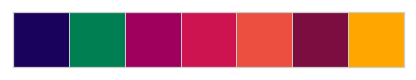

In [24]:
#Creating my own pallete
my_pallete = ['#18025c','#008052','#9f005d','#cd1450','#ec4f3f','#7c0d40','#ffa600']
sns.set_palette(my_pallete)
sns.palplot(sns.color_palette()) #Setting your own palle

In [25]:
df4 = df3.groupby('listed_in(type)')

In [26]:
df4.head()

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Lajawab, Tomato Shorba, Dum Biryani, Sweet Corn Soup","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only ...",Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai Green Curry, Paneer Tikka, Dum Biryani, Chicken Biryani","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for dinner with family. Turned out to be a good choose suitable for all ages of people. Can try this place. We liked the most was their starters. Service is ...",Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Chocolate, Pink Sauce Pasta, Salsa, Veg Supreme Pizza","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that good enough and it's not a pocket friendly cafe and the quantity is not that good and desserts are too good enough ??..""), ('Rated 3.0', ""RATED\n \nWe...",Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper Karnataka style full meals. Been there twice and was fully satisfied.. Will give 5 stars if it's well managed............""), ('Rated 2.0', 'RATED\n ...",Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant in neighbourhood. Buffet system is properly arranged. Variety of dishes along with garba dance and puppet show. Good spread of desserts. Live paratha ...",Buffet,Banashankari
7,Onesta,Yes,Yes,4.6,2556,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Mojito, Pasta, Paneer Tikka, Lime Soda, Prawn Pizza","Pizza, Cafe, Italian",600.0,"[('Rated 5.0', 'RATED\n I personally really liked this place ! The ambience with the rooftop , plants , the music is great !\nThe starters are good and so were the pizzas.\nThe prices are pretty ...",Cafes,Banashankari
8,Penthouse Cafe,Yes,No,4.0,324,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta, Sandwiches","Cafe, Italian, Continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this place with one of my friends, it's a very small place but decent. And nice place to hangout.\nFood-3.5/5\nAmbience-4/5\nValue for money 3.5/5""), ('Rated...",Cafes,Banashankari
9,Smacznego,Yes,No,4.2,504,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffle, Tacos, Momos, Cheese Nachos","Cafe, Mexican, Italian, Momos, Beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3.5/5\nTaste 5/5\nYummy cheesyyy fries ?\nDelicious pasta\nThey're a must try ??\nLoaded nachos and green fries are average!!""), ('Rated 4.0', 'RATED\n...",Cafes,Banashankari
10,CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© Down The Alley,Yes,No,4.1,402,Banashankari,Cafe,"Waffles, Pasta, Crispy Chicken, Honey Chilli Chicken, Sandwich, Coffee, Crepe",Cafe,500.0,"[('Rated 4.0', 'RATED\n We ended up here on a Saturday afternoon after an hectic day\nThe food was too good\nThe ambience is okay\nBut usually itÃ\x83Ã\x83Ã\x82Ã\x82Ã\x83Ã\x82Ã\x82Ã\x92s ...",Cafes,Banashankari
11,Cafe Shuffle,Yes,Yes,4.2,150,Banashankari,Cafe,"Mocktails, Peri Fries, Lasagne, Pizza, Chicken Bbq Wings, Virgin Mojito, Nachos","Cafe, Italian, Continental",600.0,"[('Rated 1.0', ""RATED\n \n\nHorrible. Not even kidding. We ordered BBQ chicken wings and chef's special pizza. They gave undercooked chicken wings and the sauce on it was not even BBQ sauce. It wa...",Cafes,Banashan

(0, 4.5)

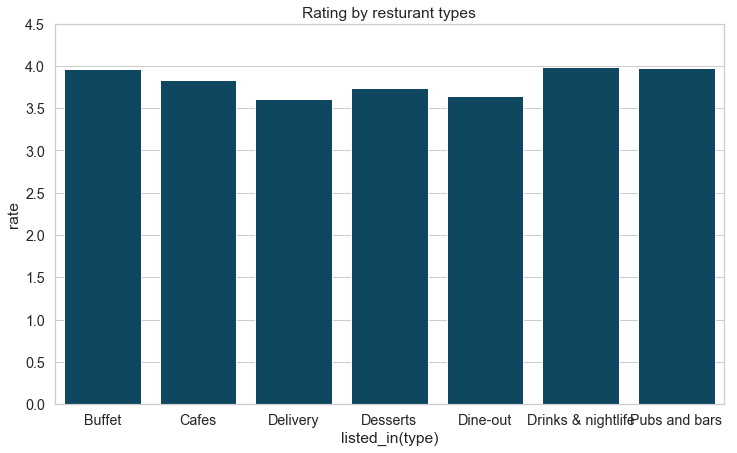

In [27]:

fig = plt.subplots(figsize=(12, 7))
ax = sns.barplot(x = 'listed_in(type)', y = 'rate', data = df3 , ci = None,color='#004c6d').set_title('Rating by resturant types')
ax = plt.gca()
ax.set_ylim([0,4.5])

In [28]:
#df4 = df3.copy(deep = True)

In [29]:
#df4['rest_type'] = df4['rest_type'].apply(lambda x : x.split(',',1)[0])

In [30]:
#word.split(',', 1)[0]

<font size="4">**Average cost by resturant type**</font>

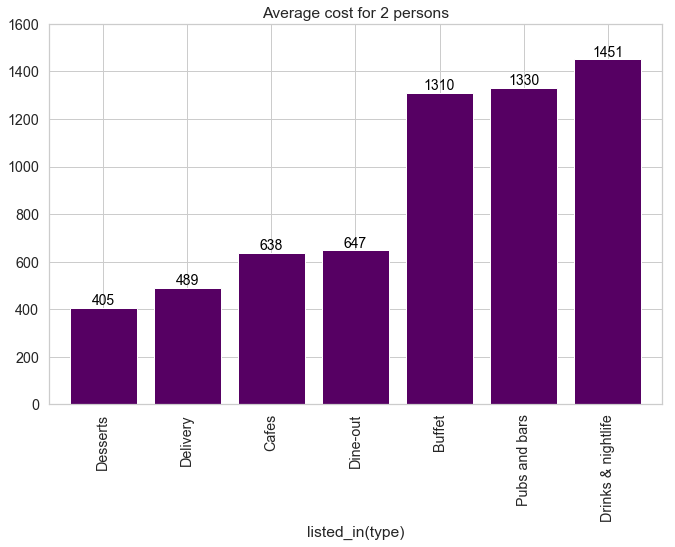

In [31]:
fig = plt.subplots(figsize=(11, 7))
ax = df3.groupby('listed_in(type)')['approx_cost'].mean().sort_values(ascending = True).plot(kind = 'bar',color = '#560063',title ='Average cost for 2 persons',width = 0.8)
ax = plt.gca()
ax.set_ylim([0,1600]) #to set limit on y axis
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=14, color='Black', ha='center', va='bottom')

plt.show()

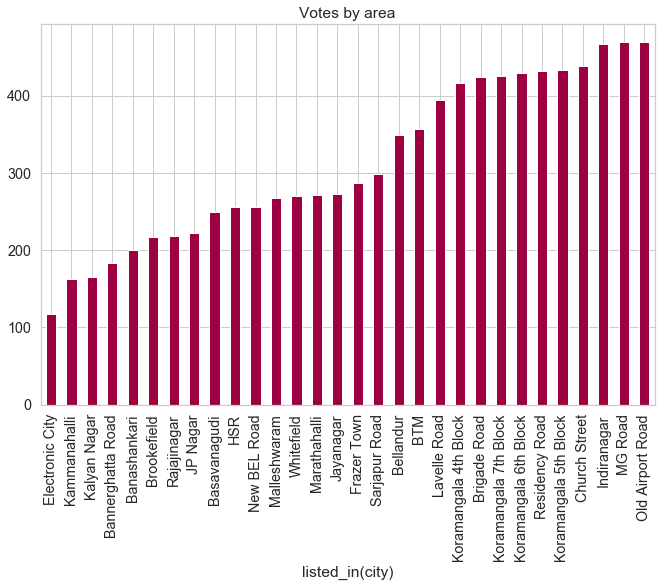

In [32]:
fig = plt.subplots(figsize=(11, 7))
ax = df3.groupby('listed_in(city)')['votes'].mean().sort_values(ascending = True).plot(kind = 'bar',colormap = 'Spectral',title ='Votes by area')


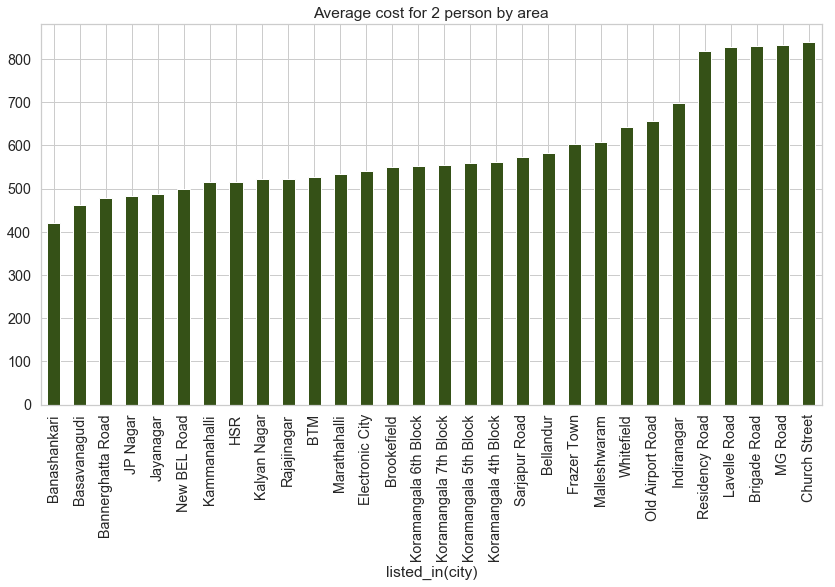

In [33]:
fig = plt.subplots(figsize=(14, 7))
ax = df3.groupby('listed_in(city)')['approx_cost'].mean().sort_values(ascending = True).plot(kind = 'bar',color = '#355117',title ='Average cost for 2 person by area')

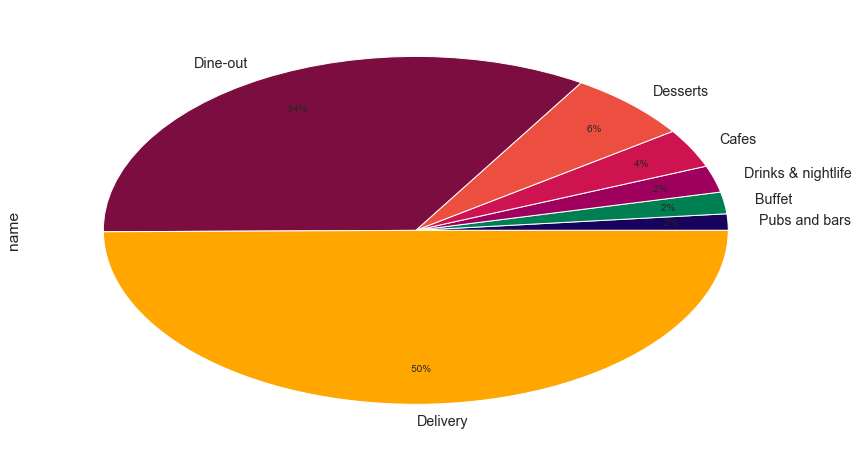

In [34]:
fig = plt.subplots(figsize=(14,8))
plt.gca()
ax= df3.groupby('listed_in(type)')['name'].count().sort_values().plot(kind = 'pie', autopct='%5.0f%%', pctdistance=.8,startangle=0)


In [35]:
df6 = pd.DataFrame(df3.groupby('listed_in(type)')['name'].count()/len(df3)*100)

In [36]:
df6.rename(columns={'name':'percentage occurence'})

,percentage occurence
listed_in(type),
Buffet,2.014251
Cafes,3.620995
Delivery,49.869598
Desserts,6.489847
Dine-out,34.002422
Drinks & nightlife,2.479974
Pubs and bars,1.522914


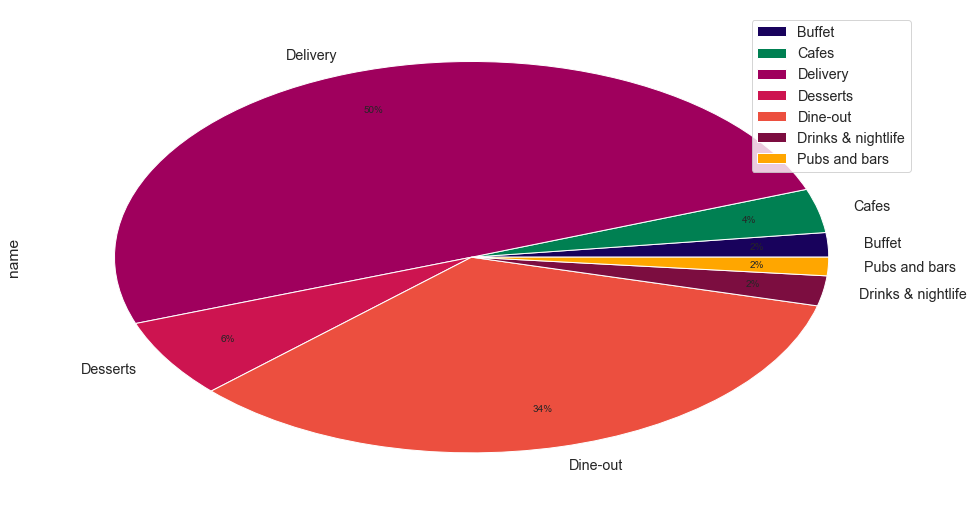

In [37]:
ax= df6.plot(kind = 'pie', autopct='%1.0f%%',pctdistance=.8,subplots = True,figsize = (16,9),layout = None)

In [38]:
df3['dish_liked'].value_counts()

None                                                                                           19751
Biryani                                                                                          181
Chicken Biryani                                                                                   73
Friendly Staff                                                                                    69
Waffles                                                                                           68
                                                                                               ...  
Salads, Chicken Curry, Pasta, Lime Soda Sweet, Lunch Buffet, Cheesecake, Rara Meat                 1
Egg Biryani, Egg Chilli, Mutton Biryani, Hyderabadi Biryani, Naan, Raita, Shanmukha Biryani        1
Rava Idli, Filter Coffee, Ghee Masala Dosa, Badam Halwa, Upma, Raita, Rasam Rice                   1
Biryani, Roti, Fish, Rice Bowls                                                            

In [39]:
def func2(df, col):
    my_list = []
    for i in df[col]:
        list = i.split(',')
        my_list.extend(list)
    return my_list

In [40]:
df_most_liked_dish = pd.DataFrame(func2(df3,'dish_liked'))

In [41]:
df_most_liked_dish.columns = ['dish_name']

In [42]:
df_most_liked_dish.drop(df_most_liked_dish[df_most_liked_dish['dish_name'] == 'None'].index, inplace = True)

In [43]:
df_most_liked_dish = pd.DataFrame(df_most_liked_dish['dish_name'].value_counts())

In [44]:
df_most_liked_dish.head(10)

,dish_name
Pasta,2660
Pizza,1917
Cocktails,1876
Burgers,1728
Mocktails,1599
Biryani,1316
Sandwiches,1281
Burgers,1240
Nachos,1171
Coffee,1156


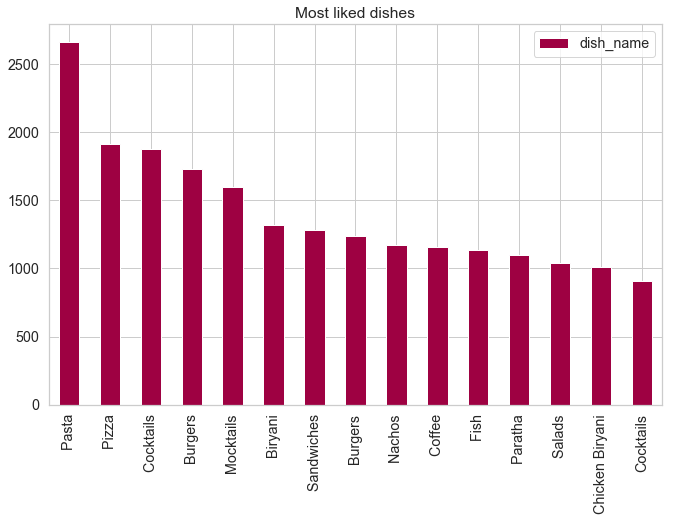

In [45]:
df_most_liked_dish.head(15).plot(kind = 'bar',colormap = 'Spectral',title ='Most liked dishes',figsize=(11, 7))

In [46]:
df4 = df3.drop_duplicates(subset = 'name',keep = 'first')

<br>

### Most liked Cuisines

In [47]:
def func2(df,col):
    my_list2 = []
    for i in df[col]:
        list = i.split(',')
        my_list2.extend(list)
    return my_list2

In [48]:
df_most_liked_cuisine = pd.DataFrame(func2(df4,'cuisines'))

In [49]:
df_most_liked_cuisine.columns = ['cuisine_type']

In [50]:
df_most_liked_cuisine['cuisine_type'] = df_most_liked_cuisine['cuisine_type'].apply(lambda x : x.replace(' ',''))

In [51]:
df_most_liked_cuisine['cuisine_type'].value_counts()

NorthIndian    3211
Chinese        2422
SouthIndian    1445
FastFood       1034
Biryani         928
               ... 
German            1
Mongolian         1
Hotdogs           1
Portuguese        1
Belgian           1
Name: cuisine_type, Length: 106, dtype: int64

In [52]:
df_most_liked_cuisine = pd.DataFrame(df_most_liked_cuisine['cuisine_type'].value_counts())

In [53]:
df_most_liked_cuisine.head()

,cuisine_type
NorthIndian,3211
Chinese,2422
SouthIndian,1445
FastFood,1034
Biryani,928


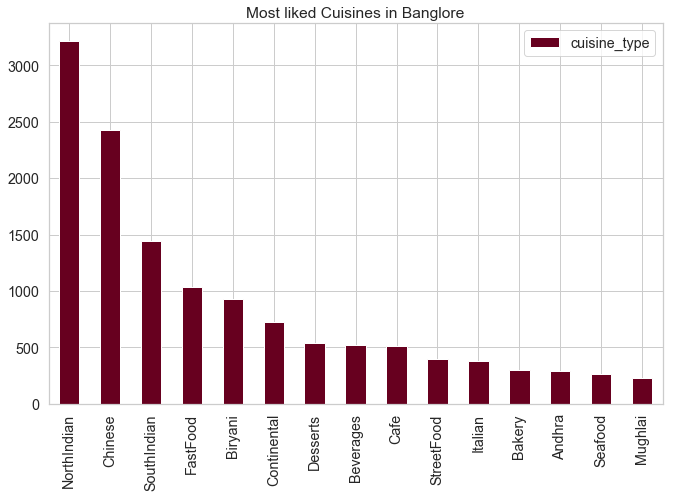

In [54]:
df_most_liked_cuisine.head(15).plot(kind = 'bar',colormap = 'RdGy',title ='Most liked Cuisines in Banglore',figsize=(11, 7))

<br>

## Applying NLP on Reviews from customers

### 1. Removing Punctuations, Numbers, and Special Characters

In [55]:
df3['reviews_list_new'] = df3['reviews_list'].str.replace("[^a-zA-Z']", " ") 

In [56]:
df3['reviews_list_new'].loc[0]

"  'Rated    '  'RATED n  A beautiful place to dine in The interiors take you back to the Mughal era  The lightings are just perfect We went there on the occasion of Christmas and so they had only limited items available  But the taste and service was not compromised at all The only complaint is that the breads could have been better Would surely like to come here again '    'Rated    '  'RATED n  I was here for dinner with my family on a weekday  The restaurant was completely empty  Ambience is good with some good old hindi music  Seating arrangement are good too  We ordered masala papad  panner and baby corn starters  lemon and corrionder soup  butter roti  olive and chilli paratha  Food was fresh and good  service is good too  Good for family hangout  nCheers'    'Rated    '  'RATED n  Its a restaurant near to Banashankari BDA  Me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet  On inquiring they said this place is mostly vis

### 2. Lower case

In [57]:
df3['reviews_list_new'] = df3['reviews_list_new'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [58]:
df3['reviews_list_new'] = df3['reviews_list_new'].str.replace("rated", " ") 

In [59]:
df3['reviews_list_new'].head()

0    '  ' '  n a beautiful place to dine in the interiors take you back to the mughal era the lightings are just perfect we went there on the occasion of christmas and so they had only limited items av...
1    '  ' '  n had been here for dinner with family turned out to be a good choose suitable for all ages of people can try this place we liked the most was their starters service is good prices are aff...
2    '  '   n ambience is not that good enough and it's not a pocket friendly cafe and the quantity is not that good and desserts are too good enough '  '   n nwent there for a quick bite with friends ...
3    '  '   n great food and proper karnataka style full meals been there twice and was fully satisfied will give stars if it's well managed '  ' '  n reached the place at pm on saturday half of the it...
4    '  ' '  n very good restaurant in neighbourhood buffet system is properly arranged variety of dishes along with garba dance and puppet show good spread of desserts live parath

<font size ='3'> Removing words with less than 3 characters like we,us etc.</font>

In [60]:
type(df3['reviews_list_new'].loc[0])

str

In [61]:
spacy_stopwords = nlp.Defaults.stop_words

In [62]:
nlp.Defaults.stop_words.add('btw')
nlp.Defaults.stop_words.add('u')
nlp.Defaults.stop_words.add('ur')
nlp.Defaults.stop_words.add('I')

# Set the stop_word tag on the lexeme
nlp.vocab['btw'].is_stop = True
nlp.vocab['u'].is_stop = True
nlp.vocab['ur'].is_stop = True
nlp.vocab['I'].is_stop = True

In [63]:
def func_stop_spacy(x):
      tokens = x.split()
#     doc = nlp(x)
#     tokens = [token.text for token in doc if not token in spacy_stopwords]
      tokens = [token for token in tokens if not token in spacy_stopwords]
      return tokens

In [64]:
df3['reviews_list_new'] = df3['reviews_list_new'].apply(func_stop_spacy)

In [65]:
df3['reviews_list_new'].loc[7]

["'",
 "'",
 "'",
 'n',
 'personally',
 'liked',
 'place',
 'ambience',
 'rooftop',
 'plants',
 'music',
 'great',
 'nthe',
 'starters',
 'good',
 'pizzas',
 'nthe',
 'prices',
 'pretty',
 'affordable',
 'visit',
 'place',
 "'",
 "'",
 "'",
 "'",
 'n',
 'good',
 'pizza',
 'took',
 'unlimited',
 'pizza',
 'eat',
 'pizzas',
 'easily',
 'person',
 'service',
 'good',
 'staff',
 'courteous',
 "polite'",
 "'",
 "'",
 "'",
 'n',
 'onward',
 'favourite',
 'place',
 'pizza',
 'time',
 'happy',
 'hour',
 'pizzas',
 'pizza',
 'combos',
 'relished',
 'pizzas',
 'fluffy',
 'right',
 'sauce',
 'toppings',
 'cheer',
 "'",
 "'",
 "'",
 "'",
 'n',
 'onesta',
 'serves',
 'unlimited',
 'pizza',
 'desserts',
 'pasta',
 'nthis',
 'places',
 'multiple',
 'branches',
 'city',
 'usually',
 'crowded',
 'weekends',
 'nservice',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 's',
 'good',
 'decent',
 'nprices',
 'affordable',
 'nfood',
 'desserts',
 'shakes',
 'good',
 'nbut',
 'pizzas',
 'thick',
 'base',
 '

In [66]:
df3['reviews_list_11'] = df3['reviews_list_new'].apply(lambda x: [w for w in x if len(w)>2])

In [67]:
df3['reviews_list_11'].loc[7]

['personally',
 'liked',
 'place',
 'ambience',
 'rooftop',
 'plants',
 'music',
 'great',
 'nthe',
 'starters',
 'good',
 'pizzas',
 'nthe',
 'prices',
 'pretty',
 'affordable',
 'visit',
 'place',
 'good',
 'pizza',
 'took',
 'unlimited',
 'pizza',
 'eat',
 'pizzas',
 'easily',
 'person',
 'service',
 'good',
 'staff',
 'courteous',
 "polite'",
 'onward',
 'favourite',
 'place',
 'pizza',
 'time',
 'happy',
 'hour',
 'pizzas',
 'pizza',
 'combos',
 'relished',
 'pizzas',
 'fluffy',
 'right',
 'sauce',
 'toppings',
 'cheer',
 'onesta',
 'serves',
 'unlimited',
 'pizza',
 'desserts',
 'pasta',
 'nthis',
 'places',
 'multiple',
 'branches',
 'city',
 'usually',
 'crowded',
 'weekends',
 'nservice',
 'good',
 'decent',
 'nprices',
 'affordable',
 'nfood',
 'desserts',
 'shakes',
 'good',
 'nbut',
 'pizzas',
 'thick',
 'base',
 'ones',
 'order',
 'cheesy',
 'generous',
 'topping',
 'taste',
 'nthe',
 'choclate',
 'banana',
 'pizza',
 'disappointment',
 "raw'",
 'like',
 'going',
 'place',

In [68]:
df3['tidy_reviews_list'] = df3['reviews_list_11'].apply(lambda x: " ".join(str(i) for i in x))

In [69]:
df3['tidy_reviews_list'].shape

(42944,)

### Removing most common occuring words

In [70]:
 freq = pd.Series(' '.join(df3['tidy_reviews_list']).split()).value_counts()[:6]
 freq

place      950453
good       902517
food       869866
chicken    389901
service    314079
ordered    296197
dtype: int64

In [71]:
 freq2 = pd.Series(' '.join(df3['tidy_reviews_list']).split()).value_counts()[:10]
 freq2

place       950453
good        902517
food        869866
chicken     389901
service     314079
ordered     296197
great       270058
ambience    257806
taste       250731
try         223318
dtype: int64

In [ ]:
# # freq_df = pd.DataFrame(freq, columns = ['a'])
# # freq_list = list(freq_df['a'])
# freq_list = ['place','good','food']
# df3['tidy_reviews_list'] = df3['tidy_reviews_list'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_list))
# df3['tidy_reviews_list'].head()

### Visualization Using WordCloud

In [73]:
from wordcloud import WordCloud

In [74]:
def func_visualize(list_of_words):
     wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(list_of_words)
     plt.figure(figsize=(10, 7)) 
     plt.imshow(wordcloud, interpolation="bilinear") 
     plt.axis('off') 
     plt.show()

### Best reviews

<font size ='3'> Most occuring words in best reviews</font>

In [75]:
normal_words =' '.join([text for text in df3['tidy_reviews_list'][df3['rate'] > 4.2]])

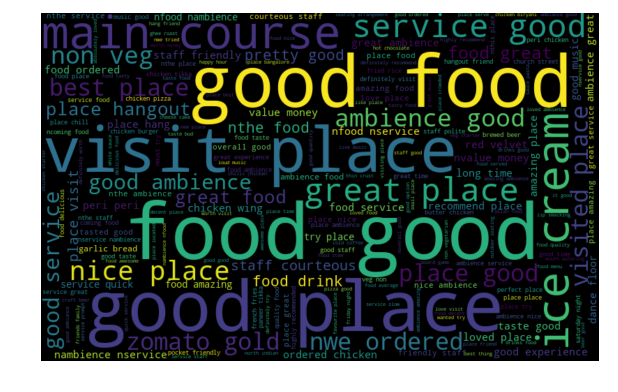

In [76]:
func_visualize(normal_words)

<font size = '4'>The above visualization tells us that Quality of main course, service, ambience and nature of staff is the most important judging criterion for the customers in banglore.</font>

In [77]:
df3['tidy_reviews_list'][df3['rate'] < 3].shape

(2250,)

### Bad reviews

<font size = '3'> Most occuring words in less than average reviews</font>

In [78]:
normal_words2 =' '.join([text for text in df3['tidy_reviews_list'][df3['rate'] < 3]])

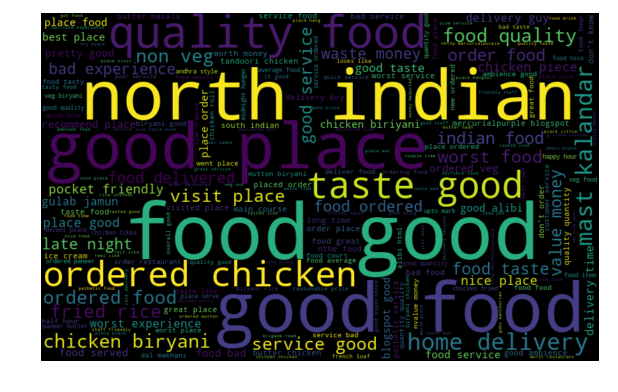

In [79]:
func_visualize(normal_words2)

<font size = '4'>The above visualization tells us that north indian food, non veg food and delivered food is not good in banglore.</font>

In [80]:
list_adjectives = []

In [81]:
list_adjectives =  df3['tidy_reviews_list'][df3['rate'] > 4.2].loc[0:4000].apply(lambda x: [token.text for token in nlp(x) if (token.pos_ == 'ADJ' )])

In [82]:
df_good_reviews = pd.DataFrame(list_adjectives)

<br>


In [83]:
df_good_reviews['Tidy_good_review'] = df_good_reviews['tidy_reviews_list'].apply(lambda x: " ".join(str(i) for i in x))

In [84]:
df_good_reviews.head(2)

,tidy_reviews_list,Tidy_good_review
7,"[great, nthe, good, nthe, affordable, good, unlimited, good, courteous, favourite, fluffy, right, unlimited, nthis, multiple, good, decent, affordable, nfood, good, thick, cheesy, generous, nthe, ...",great nthe good nthe affordable good unlimited good courteous favourite fluffy right unlimited nthis multiple good decent affordable nfood good thick cheesy generous nthe cool nice famous generous...
38,"[recent, past, late, quick, crowded, usual, good, narabian, great, fine, quick, odd, nice, good, worth, special, yummy, good, big, veg, reasonable, easy, favorite, veg, veg, good, polite, professi...",recent past late quick crowded usual good narabian great fine quick odd nice good worth special yummy good big veg reasonable easy favorite veg veg good polite professional good open late big sout...


In [85]:
normal_good_words =' '.join([text for text in df_good_reviews['Tidy_good_review']])

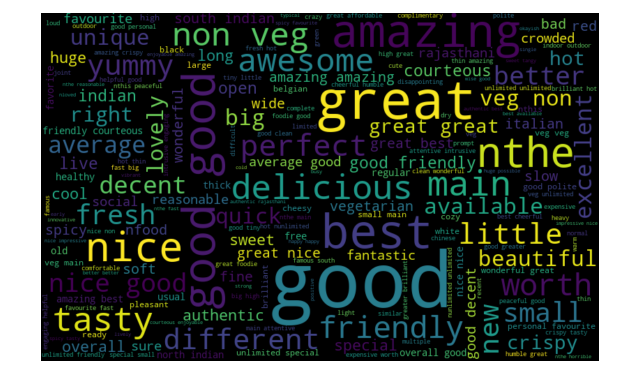

In [86]:
func_visualize(normal_good_words)

In [88]:
list_bad_adjectives = []

In [89]:
list_bad_adjectives =  df3['tidy_reviews_list'][df3['rate'] <= 3.0].loc[0:2200].apply(lambda x: [token.text for token in nlp(x) if (token.pos_ == 'ADJ' )])

In [90]:
df_bad_reviews = pd.DataFrame(list_bad_adjectives)

In [91]:
df_bad_reviews['Tidy_bad_review'] = df_bad_reviews['tidy_reviews_list'].apply(lambda x: " ".join(str(i) for i in x))

In [92]:
df_bad_reviews.head(2)

,tidy_reviews_list,Tidy_bad_review
20,"[tiny, nice, indian, american, good, iced, vintage, terrible, worst, worth, small, poor, tiny, vintage, veg, great, decorative, peaceful, good, good, bad]",tiny nice indian american good iced vintage terrible worst worth small poor tiny vintage veg great decorative peaceful good good bad
31,"[worst, tiny, fro, sorry, small, disgusting, good, disappointed, dead, worst, plain, pathetic, hungry, dear, unable, late, good, late, good, worst, worst, small, big, small, bad, pathetic, nice, f...",worst tiny fro sorry small disgusting good disappointed dead worst plain pathetic hungry dear unable late good late good worst worst small big small bad pathetic nice french tasty good good upset ...


In [93]:
normal_bad_words =' '.join([text for text in df_bad_reviews['Tidy_bad_review']])

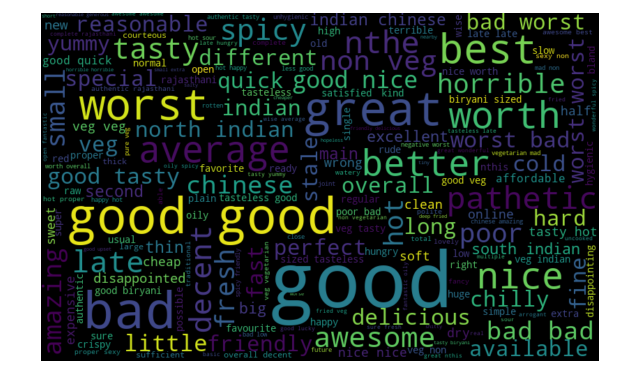

In [94]:
func_visualize(normal_bad_words)

<br>

## DEFINING BEST RESTURANT ON THE BASIS OF 3 PARAMETERS

#### 1. No. of Votes - (Reliability)
#### 2. Rating
#### 3. Average Cost

In [95]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42944 entries, 0 to 51716
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               42944 non-null  object 
 1   online_order       42944 non-null  object 
 2   book_table         42944 non-null  object 
 3   rate               42944 non-null  float64
 4   votes              42944 non-null  int64  
 5   location           42944 non-null  object 
 6   rest_type          42944 non-null  object 
 7   dish_liked         42944 non-null  object 
 8   cuisines           42944 non-null  object 
 9   approx_cost        42944 non-null  float64
 10  reviews_list       42944 non-null  object 
 11  listed_in(type)    42944 non-null  object 
 12  listed_in(city)    42944 non-null  object 
 13  reviews_list_new   42944 non-null  object 
 14  reviews_list_11    42944 non-null  object 
 15  tidy_reviews_list  42944 non-null  object 
dtypes: float64(2), int64(1

In [96]:
df_3 = df3[['name','rate','votes','dish_liked','approx_cost','listed_in(type)']]

In [97]:
df_3= df_3.drop_duplicates(subset='name',keep='first')

In [98]:
Q3_votes = np.percentile(df_3['votes'],75)

In [99]:
df_3_most_reliable = df_3[df_3['votes']> Q3_votes ]

In [100]:
df_3_affordable = df_3[df_3['approx_cost'] <  1500] #Resturants lower than 25 quaruntile in terms of cost

In [ ]:
#Q3_rateing = np.percentile(df_3['rate'],75)

In [101]:
df_3_highest_rated = df_3[df_3['rate'] >= 4.5 ]

In [102]:
df_best_1 = pd.merge(df_3_highest_rated,df_3_affordable,how='inner',on=['name'])

In [103]:
df_best_1.shape

(74, 11)

In [104]:
df_best = pd.merge(df_best_1,df_3_most_reliable,how='inner',on=['name'])

In [105]:
df_best = df_best.iloc[0:,:6]

In [106]:
df_best

,name,rate_x,votes_x,dish_liked_x,approx_cost_x,listed_in(type)_x
0,Onesta,4.6,2556,"Farmhouse Pizza, Chocolate Banana, Virgin Mojito, Pasta, Paneer Tikka, Lime Soda, Prawn Pizza",600.0,Cafes
1,The Blue Wagon - Kitchen,4.6,228,"Pizza, Nachos, Garlic Maggi, Burgers, Cheese Maggi, Bruschetta Bites, Sandwich",400.0,Delivery
2,Shakes Theory,4.5,155,"Sandwiches, Thick Shakes, Paan Shake, Brownie Bomb, Fries, Spinach Corn Sandwich, Paneer Peri Peri",300.0,Delivery
3,Taaza Thindi,4.7,651,"Masala Dosa, Vada, Upma, Filter Coffee, Kesari Bath, Idli Chutney, Kharabath",100.0,Dine-out
4,Galito's,4.6,404,"Chicken Grill, Garlic Bread, Mocktails, Burgers, Fries, Salads, Pudding",1000.0,Delivery
...,...,...,...,...,...,...
63,O.G. Variar & Sons,4.8,1156,"Veg Puff, Plum Cake, Sponge Cake, Tea, Coconut Biscuits, Fruit Cake, Apple Cake",200.0,Desserts
64,Barbecue by Punjab Grill,4.7,1316,"Prawn, Panipuri, Chaat, Biryani, Paan Ice Cream, Brownie, Tandoori Prawns",1300.0,Dine-out
65,The London Curry House - The Royale Senate Hotel,4.5,3953,"Soan Papdi, Mocktails, Panipuri, Kulfi, Cocktails, Misal Pav, Honey Chilli Potatoes",1300.0,Dine-out
66,Output Bengaluru,4.5,900,"Prawn, Cocktails, Nachos, Pizza, Craft Beer, Fries, Crispy Corn",1000.0,Dine-out
